In [17]:
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(123)
tf.compat.v1.set_random_seed(123)


In [18]:
tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

In [19]:
#load dataset
from molmap import dataset
data = dataset.load_CYP450()
df = data.data
X_smiles = df.smiles.tolist()
task_name = 'CYP450'


total samples: 16896


In [20]:
MASK = -1
tasks = ['label_1a2', 'label_2c19', 'label_2c9', 'label_2d6', 'label_3a4']
Y = df[tasks].astype('float').fillna(MASK).values
if Y.shape[1] == 0:
    Y = Y.reshape(-1, 1)

# featurizer

In [21]:
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]

# splitting valid set from training set by scaffold

In [22]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit import Chem
getSFD = lambda x:Chem.MolToSmiles(GetScaffoldForMol(Chem.MolFromSmiles(x)))

df['scaffold'] = df.smiles.progress_apply(getSFD)
df_train = df[df['group'] == 'training set'][['scaffold']]
def getValidIdx(x):
    if (len(x) > 2): # set as valid only if this scaffold group larger than 5
        return x.index.tolist()[0]
    else:
        return 
valid_idx = df_train.groupby('scaffold').progress_apply(getValidIdx).dropna().astype(int).tolist()
train_idx = list(set(df_train.index.tolist()) - set(valid_idx))
test_idx = df[df.group == 'test set'].index.tolist()
print(len(train_idx), len(valid_idx), len(test_idx))

train_df = df.iloc[train_idx]
valid_df = df.iloc[valid_idx]
test_df = df.iloc[test_idx]

train_df.to_csv('./train.csv')
valid_df.to_csv('./valid.csv')
test_df.to_csv('./test.csv')

100%|##########| 8163/8163 [00:00<00:00, 84210.42it/s]


12827 760 3309


In [23]:
trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

In [24]:
def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

pos_weights, neg_weights = get_pos_weights(Y[train_idx])
pos_weights

array([1.66239571, 1.23172738, 2.6004065 , 6.43569758, 1.93945648])

In [25]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0
monitor = 'val_loss'

dense_avf = 'relu'
last_avf = None #sigmoid in loss

In [26]:
import tensorflow_addons as tfa
loss = lambda y_true, y_pred: molmodel.loss.weighted_cross_entropy(y_true,y_pred, pos_weights, MASK = -1)
opt = tfa.optimizers.AdamW(weight_decay = 0.0,learning_rate=lr)

model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                   n_outputs=Y.shape[-1], 
                                   dense_layers=dense_layers, 
                                   dense_avf = dense_avf, 
                                   last_avf=last_avf)
model.compile(optimizer = opt, loss = loss)

performance = molmodel.cbks.CLA_EarlyStoppingAndPerformance((trainX, trainY), 
                                                            (validX, validY), 
                                                            metric = 'ROC',
                                                            patience = patience, 
                                                            criteria = monitor)


In [27]:
model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performance]) 

epoch: 0001, loss: 0.8363 - val_loss: 0.7283; auc: 0.7827 - val_auc: 0.8124                                                                                                    
epoch: 0002, loss: 0.7417 - val_loss: 0.6499; auc: 0.8377 - val_auc: 0.8700                                                                                                    
epoch: 0003, loss: 0.6926 - val_loss: 0.6338; auc: 0.8573 - val_auc: 0.8852                                                                                                    
epoch: 0004, loss: 0.6648 - val_loss: 0.5954; auc: 0.8699 - val_auc: 0.8952                                                                                                    
epoch: 0005, loss: 0.6516 - val_loss: 0.5825; auc: 0.8769 - val_auc: 0.9017                                                                                                    
epoch: 0006, loss: 0.6406 - val_loss: 0.5672; auc: 0.8828 - val_auc: 0.9062                                             

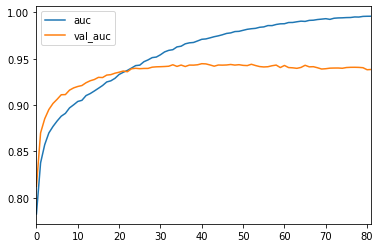

In [28]:
pd.DataFrame(performance.history)[['auc', 'val_auc']].plot()

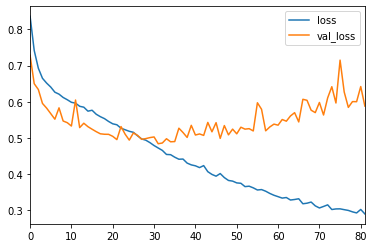

In [29]:
pd.DataFrame(performance.history)[['loss', 'val_loss']].plot()

In [30]:
best_epoch = performance.best_epoch
trainable_params = model.count_params()

train_aucs = performance.evaluate(trainX, trainY)            
valid_aucs = performance.evaluate(validX, validY)            
test_aucs = performance.evaluate(testX, testY)


final_res = {
                 'task_name':task_name,            
                 'train_auc':np.nanmean(train_aucs), 
                 'valid_auc':np.nanmean(valid_aucs),                      
                 'test_auc':np.nanmean(test_aucs), 
                 '# trainable params': trainable_params,
                 'best_epoch': best_epoch,
                 'batch_size':batch_size,
                 'lr': lr,
                 'weight_decay':weight_decay
                }

final_res

{'task_name': 'CYP450',
 'train_auc': 0.9573297428637668,
 'valid_auc': 0.9415995864301809,
 'test_auc': 0.8748443095521777,
 '# trainable params': 803813,
 'best_epoch': 31,
 'batch_size': 128,
 'lr': 0.0001,
 'weight_decay': 0}

In [31]:
[round(i, 3) for i in performance.evaluate(testX, testY)]

[0.976, 0.801, 0.799, 0.879, 0.919]

In [32]:
model.save('./model_final.h5')